In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from functions import ReturnsClusteringAnalysis

Plotting Style

In [2]:
plt.style.use('default')
sns.set_palette("husl")

Connect to DB

In [3]:
conn = duckdb.connect('returns.db')

Run once! Build DB from .xlsx

In [4]:

# conn.execute("INSTALL 'excel'")
# conn.execute("LOAD 'excel'")
# table = 'temp_returns'
# file = 'RETRO_SAMPLE.xlsx'
# conn.execute("CREATE TABLE returns AS SELECT * FROM RETRO_SAMPLE.xlsx")

DuckDB Data

In [5]:
tables = conn.execute("SHOW TABLES").fetchall()
print(tables)

columns = conn.execute("PRAGMA table_info('returns');").fetchall()
print(columns)

query = conn.execute("""

    SELECT COUNT(DISTINCT CUSTOMER_EMAILID)
    FROM returns
""").fetchone()

print(f"unqiue customer emails: {query}")

cust_orders = conn.execute("""
    SELECT AVG(order_count) AS avg_unique_orders_per_customer
    FROM (
        SELECT CUSTOMER_EMAILID, COUNT(DISTINCT SALES_ORDER_NO) AS order_count
        FROM returns
        GROUP BY CUSTOMER_EMAILID
    );
        """).fetchone()

print(f"average unique orders per customer: {cust_orders}")

cust_returns = conn.execute("""
    SELECT AVG(return_count) AS avg_unique_returns_per_customer
    FROM (
        SELECT CUSTOMER_EMAILID, COUNT(DISTINCT RETURN_NO) AS return_count
        FROM returns
        GROUP BY CUSTOMER_EMAILID
    );
        """).fetchone()

print(f"average unique returns per customer: {cust_returns}")

[('returns',)]
[(0, 'CUSTOMER_EMAILID', 'VARCHAR', False, None, False), (1, 'SALES_ORDER_NO', 'VARCHAR', False, None, False), (2, 'Q_GMM_ID', 'DOUBLE', False, None, False), (3, 'Q_CLS_ID', 'DOUBLE', False, None, False), (4, 'SKU', 'VARCHAR', False, None, False), (5, 'Q_SKU_DESC', 'VARCHAR', False, None, False), (6, 'SALES_QTY', 'DOUBLE', False, None, False), (7, 'UNITS_RETURNED_FLAG', 'VARCHAR', False, None, False), (8, 'RETURN_NO', 'VARCHAR', False, None, False), (9, 'RETURN_QTY', 'DOUBLE', False, None, False), (10, 'ORDER_DATE', 'DATE', False, None, False), (11, 'RETURN_DATE', 'VARCHAR', False, None, False)]
unqiue customer emails: (15608,)
average unique orders per customer: (24.284405433111225,)
average unique returns per customer: (10.931060994361866,)


Load Data

In [6]:

print("build df from returns table...")
df = conn.execute("SELECT * FROM returns").df()
print("data loaded successfully.")

build df from returns table...
data loaded successfully.


Test Date data

In [7]:
# Advanced return date diagnostic
print("=== DETAILED RETURN DATE ANALYSIS ===")

# Check the data after conversion
df_test = df.copy()
df_test['RETURN_DATE_PARSED'] = pd.to_datetime(df_test['RETURN_DATE'], format='%m/%d/%Y', errors='coerce')

print(f"Total records: {len(df_test):,}")
print(f"Records with RETURN_QTY > 0: {(df_test['RETURN_QTY'] > 0).sum():,}")
print(f"Records with non-dash RETURN_DATE: {(df_test['RETURN_DATE'] != '-').sum():,}")
print(f"Records with valid parsed RETURN_DATE: {df_test['RETURN_DATE_PARSED'].notna().sum():,}")

# Show some examples of successfully parsed dates
valid_returns = df_test[
    (df_test['RETURN_QTY'] > 0) & 
    (df_test['RETURN_DATE_PARSED'].notna())
]

if len(valid_returns) > 0:
    print(f"\nValid returns with dates: {len(valid_returns):,}")
    print("Sample valid returns:")
    sample = valid_returns[['CUSTOMER_EMAILID', 'ORDER_DATE', 'RETURN_DATE', 'RETURN_DATE_PARSED', 'RETURN_QTY']].head()
    print(sample)
    
    # Calculate days to return for these samples
    df_test['ORDER_DATE_PARSED'] = pd.to_datetime(df_test['ORDER_DATE'], format='%m/%d/%Y')
    valid_returns_with_timing = valid_returns.copy()
    valid_returns_with_timing['DAYS_TO_RETURN'] = (
        valid_returns_with_timing['RETURN_DATE_PARSED'] - 
        pd.to_datetime(valid_returns_with_timing['ORDER_DATE'], format='%m/%d/%Y')
    ).dt.days
    
    print(f"\nSample return timing:")
    timing_sample = valid_returns_with_timing[['CUSTOMER_EMAILID', 'ORDER_DATE', 'RETURN_DATE', 'DAYS_TO_RETURN']].head()
    print(timing_sample)
    
    print(f"\nReturn timing stats:")
    print(f"Min days to return: {valid_returns_with_timing['DAYS_TO_RETURN'].min()}")
    print(f"Max days to return: {valid_returns_with_timing['DAYS_TO_RETURN'].max()}")
    print(f"Average days to return: {valid_returns_with_timing['DAYS_TO_RETURN'].mean():.1f}")
else:
    print("\nNo valid return dates found!")
    print("Checking specific return date formats:")
    non_dash_dates = df_test[df_test['RETURN_DATE'] != '-']['RETURN_DATE'].unique()[:10]
    print(f"Sample non-dash return dates: {non_dash_dates}")

=== DETAILED RETURN DATE ANALYSIS ===
Total records: 1,048,565
Records with RETURN_QTY > 0: 271,409
Records with non-dash RETURN_DATE: 271,409
Records with valid parsed RETURN_DATE: 0

No valid return dates found!
Checking specific return date formats:
Sample non-dash return dates: ['45205.437708333331' '45255.554062499999' '45318.55190972222'
 '45354.631018518521' '45367.598333333342' '45427.551516203697'
 '44898.714814814812' '44898.713576388887' '45000.762604166674'
 '45017.700636574067']


In [8]:
print("=== TESTING EXCEL DATE CONVERSION ===")
sample_excel_dates = ['45205.437708333331', '45255.554062499999', '45318.55190972222']

for excel_date in sample_excel_dates:
    converted = pd.to_datetime('1899-12-30') + pd.Timedelta(days=float(excel_date))
    print(f"Excel serial {excel_date} → {converted.strftime('%Y-%m-%d %H:%M:%S')}")

=== TESTING EXCEL DATE CONVERSION ===
Excel serial 45205.437708333331 → 2023-10-06 10:30:17
Excel serial 45255.554062499999 → 2023-11-25 13:17:50
Excel serial 45318.55190972222 → 2024-01-27 13:14:45


Quick analysis

In [9]:
print("Dataset shape:", df.shape)
print("\nColumn info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nUnique customer emails:", df['CUSTOMER_EMAILID'].nunique())
print("Average unique orders per customer:", df.groupby('CUSTOMER_EMAILID')['SALES_ORDER_NO'].nunique().mean())
print("Average unique returns per customer:", df.groupby('CUSTOMER_EMAILID')['RETURN_NO'].nunique().mean())
print("Example RETRUN_DATE rows: ", df['RETURN_DATE'].head())


Dataset shape: (1048565, 12)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048565 entries, 0 to 1048564
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   CUSTOMER_EMAILID     1048565 non-null  object        
 1   SALES_ORDER_NO       1048565 non-null  object        
 2   Q_GMM_ID             1048565 non-null  float64       
 3   Q_CLS_ID             1048565 non-null  float64       
 4   SKU                  1048565 non-null  object        
 5   Q_SKU_DESC           1048565 non-null  object        
 6   SALES_QTY            1048565 non-null  float64       
 7   UNITS_RETURNED_FLAG  1048565 non-null  object        
 8   RETURN_NO            1048565 non-null  object        
 9   RETURN_QTY           1048565 non-null  float64       
 10  ORDER_DATE           1048565 non-null  datetime64[us]
 11  RETURN_DATE          1048565 non-null  object        
dtypes: datetime64

find nulls

In [10]:
print("Missing values:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)
print("\nRETURN_DATE unique values (first 20):")
print(df['RETURN_DATE'].value_counts().head(20))
print("\nRETURN_QTY distribution:")
print(df['RETURN_QTY'].describe())
print("\nRecords with RETURN_QTY > 0:", (df['RETURN_QTY'] > 0).sum())
print("\nUnique customer emails:", df['CUSTOMER_EMAILID'].nunique())
print("Average unique orders per customer:", df.groupby('CUSTOMER_EMAILID')['SALES_ORDER_NO'].nunique().mean())
print("Average unique returns per customer:", df.groupby('CUSTOMER_EMAILID')['RETURN_NO'].nunique().mean())


Missing values:
CUSTOMER_EMAILID       0
SALES_ORDER_NO         0
Q_GMM_ID               0
Q_CLS_ID               0
SKU                    0
Q_SKU_DESC             0
SALES_QTY              0
UNITS_RETURNED_FLAG    0
RETURN_NO              0
RETURN_QTY             0
ORDER_DATE             0
RETURN_DATE            0
dtype: int64

Data types:
CUSTOMER_EMAILID               object
SALES_ORDER_NO                 object
Q_GMM_ID                      float64
Q_CLS_ID                      float64
SKU                            object
Q_SKU_DESC                     object
SALES_QTY                     float64
UNITS_RETURNED_FLAG            object
RETURN_NO                      object
RETURN_QTY                    float64
ORDER_DATE             datetime64[us]
RETURN_DATE                    object
dtype: object

RETURN_DATE unique values (first 20):
RETURN_DATE
-                     777156
44911.583460648151        42
45094.962951388887        39
45741.751030092593        36
45231.81386574074    

Build Class

In [11]:
# Initialize analyzer
print("initializing ReturnsClusteringAnalysis...")
analyzer = ReturnsClusteringAnalysis(df)
print("ReturnsClusteringAnalysis initialized.")


initializing ReturnsClusteringAnalysis...
ReturnsClusteringAnalysis initialized.


Prep Data

In [12]:
customer_features = analyzer.prepare_customer_features()
print(f"\nCustomer features created for {len(customer_features)} customers")
print("\nFeatures overview:")
print(customer_features.describe())

Analyzing combined order-return data structure...
Total records: 1,048,565
Records with returns (RETURN_QTY > 0): 271,409
Records with no returns (RETURN_QTY = 0): 777,156
Valid return dates: 271,409
Analyzing 12,709 customers who have made returns
Total records for these customers: 987,786
Items with valid return timing: 271,409

Using features for clustering: ['SALES_ORDER_NO_nunique', 'SKU_nunique', 'RETURN_RATE', 'RETURN_RATIO', 'ITEMS_RETURNED_COUNT', 'RETURN_PRODUCT_VARIETY', 'CUSTOMER_LIFETIME_DAYS', 'RECENT_ORDERS', 'RECENT_RETURNS', 'SALES_QTY_mean', 'AVG_DAYS_TO_RETURN', 'RETURN_TIMING_SPREAD', 'AVG_RETURNS_PER_ORDER', 'RETURN_FREQUENCY_RATIO', 'AVG_RETURN_INTENSITY', 'RECENT_VS_AVG_RATIO', 'RETURN_TREND_INCREASING']
Customer features created for 12,709 customers

Customer features created for 12709 customers

Features overview:
       SALES_ORDER_NO_nunique   SKU_nunique   RETURN_RATE  RETURN_RATIO  \
count            12709.000000  12709.000000  12709.000000  12709.000000   

Expected Clusters <> Feature relationships

In [13]:
# Cell: Feature Expectations & Business Logic
# ===========================================
print("="*60)
print("EXPECTED CUSTOMER SEGMENTS & FEATURE PATTERNS")
print("="*60)

expected_segments = {
    "VIP Champions": {
        "description": "High-value, low-return customers",
        "expected_features": {
            "SALES_ORDER_NO_nunique": "HIGH (30+)",
            "RETURN_RATE": "LOW (<0.2)",
            "RETURN_RATIO": "LOW (<0.15)", 
            "CUSTOMER_LIFETIME_DAYS": "HIGH (800+)",
            "RECENT_ORDERS": "MODERATE-HIGH (3+)",
            "AVG_PRODUCT_VARIETY": "HIGH (varied shopping)",
            "AVG_DAYS_TO_RETURN": "MODERATE (thoughtful returns)",
            "AVG_RETURN_INTENSITY": "LOW (partial returns)"
        },
        "marketing_action": "Premium loyalty program, exclusive access",
        "expected_size": "15-20% of returning customers"
    },
    
    "Heavy Returners": {
        "description": "High return rate customers - potential policy abusers",
        "expected_features": {
            "RETURN_RATE": "HIGH (>0.6)",
            "RETURN_RATIO": "HIGH (>0.5)",
            "AVG_RETURNS_PER_ORDER": "HIGH (5+)",
            "AVG_RETURN_INTENSITY": "HIGH (full returns)",
            "AVG_DAYS_TO_RETURN": "LOW (<10 days - quick returns)",
            "RECENT_RETURNS": "HIGH (active returners)"
        },
        "marketing_action": "Return policy enforcement, education",
        "expected_size": "5-10% of returning customers"
    },
    
    "Churn Risk": {
        "description": "Previously active but now disengaged",
        "expected_features": {
            "RETURN_RATE": "MODERATE-HIGH (tried products, returned)",
            "RECENT_ORDERS": "LOW (<2)",
            "RECENT_RETURNS": "LOW (not active recently)",
            "CUSTOMER_LIFETIME_DAYS": "HIGH (been around a while)",
            "AVG_ORDERS": "MODERATE (had some activity)"
        },
        "marketing_action": "Win-back campaigns, personalized offers",
        "expected_size": "15-25% of returning customers"
    },
    
    "Product Explorers": {
        "description": "High variety, experimental shoppers",
        "expected_features": {
            "SKU_nunique": "HIGH (top 25%)",
            "RETURN_PRODUCT_VARIETY": "HIGH (try many categories)",
            "RETURN_RATE": "MODERATE (some experimentation fails)",
            "AVG_RETURNS_PER_ORDER": "MODERATE (selective returning)",
            "CUSTOMER_LIFETIME_DAYS": "MODERATE-HIGH"
        },
        "marketing_action": "Product discovery, early access to new items",
        "expected_size": "20-30% of returning customers"
    },
    
    "Standard/Balanced": {
        "description": "Typical return behavior customers",
        "expected_features": {
            "ALL_FEATURES": "MODERATE (around median values)",
            "RETURN_RATE": "MODERATE (0.3-0.5)",
            "RETURN_RATIO": "MODERATE (0.2-0.4)",
            "RECENT_ORDERS": "MODERATE"
        },
        "marketing_action": "Standard engagement, cross-sell",
        "expected_size": "40-50% of returning customers"
    }
}

for segment_name, details in expected_segments.items():
    print(f"\n🎯 {segment_name.upper()}")
    print(f"   Description: {details['description']}")
    print(f"   Expected Size: {details['expected_size']}")
    print(f"   Key Features:")
    for feature, expectation in details['expected_features'].items():
        print(f"     • {feature}: {expectation}")
    print(f"   Marketing Action: {details['marketing_action']}")
    print("-" * 50)

print("\n" + "="*60)
print("FEATURE DISTRIBUTIONS IN YOUR DATA")
print("="*60)

# Show actual feature distributions
print("Let's see how your data compares to these expectations...")

EXPECTED CUSTOMER SEGMENTS & FEATURE PATTERNS

🎯 VIP CHAMPIONS
   Description: High-value, low-return customers
   Expected Size: 15-20% of returning customers
   Key Features:
     • SALES_ORDER_NO_nunique: HIGH (30+)
     • RETURN_RATE: LOW (<0.2)
     • RETURN_RATIO: LOW (<0.15)
     • CUSTOMER_LIFETIME_DAYS: HIGH (800+)
     • RECENT_ORDERS: MODERATE-HIGH (3+)
     • AVG_PRODUCT_VARIETY: HIGH (varied shopping)
     • AVG_DAYS_TO_RETURN: MODERATE (thoughtful returns)
     • AVG_RETURN_INTENSITY: LOW (partial returns)
   Marketing Action: Premium loyalty program, exclusive access
--------------------------------------------------

🎯 HEAVY RETURNERS
   Description: High return rate customers - potential policy abusers
   Expected Size: 5-10% of returning customers
   Key Features:
     • RETURN_RATE: HIGH (>0.6)
     • RETURN_RATIO: HIGH (>0.5)
     • AVG_RETURNS_PER_ORDER: HIGH (5+)
     • AVG_RETURN_INTENSITY: HIGH (full returns)
     • AVG_DAYS_TO_RETURN: LOW (<10 days - quick retu

finding optimal number of clusters...


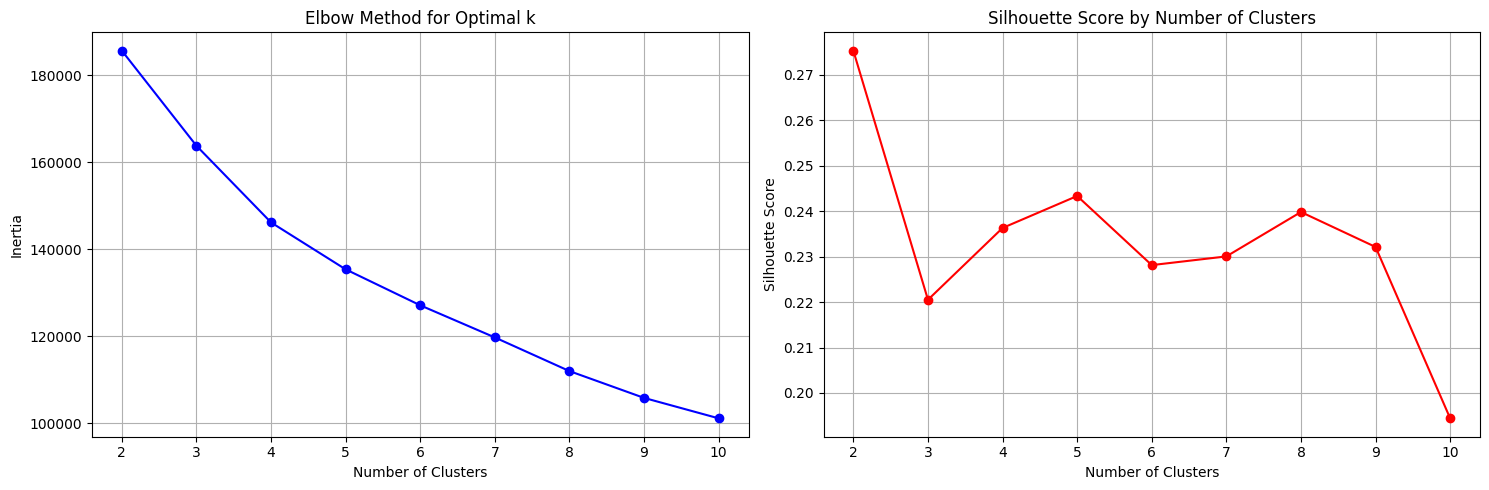

Recommended number of clusters: 2
Silhouette score: 0.275
Optimal number of clusters found: 2
Using different clustesr for testing...


In [14]:
# Find optimal number of clusters
print("finding optimal number of clusters...")
optimal_k, scores = analyzer.find_optimal_clusters()
print(f"Optimal number of clusters found: {optimal_k}")
print("Using different clustesr for testing...")


Testing with 5 clusters

In [15]:
print(f"\n=== FINAL CLUSTERING WITH 5 SEGMENTS ===")
cluster_labels, cluster_centers = analyzer.perform_clustering(n_clusters=5)
print("Analyzing cluster characteristics...")
cluster_summary, interpretations = analyzer.analyze_clusters()


=== FINAL CLUSTERING WITH 5 SEGMENTS ===
No optimization run found - using current features
Features for clustering: ['SALES_ORDER_NO_nunique', 'SKU_nunique', 'RETURN_RATE', 'RETURN_RATIO', 'ITEMS_RETURNED_COUNT', 'RETURN_PRODUCT_VARIETY', 'CUSTOMER_LIFETIME_DAYS', 'RECENT_ORDERS', 'RECENT_RETURNS', 'SALES_QTY_mean', 'AVG_DAYS_TO_RETURN', 'RETURN_TIMING_SPREAD', 'AVG_RETURNS_PER_ORDER', 'RETURN_FREQUENCY_RATIO', 'AVG_RETURN_INTENSITY', 'RECENT_VS_AVG_RATIO', 'RETURN_TREND_INCREASING']
Number of features: 17
Using existing scaler parameters
Scaled data shape: (12709, 17)
Analyzing cluster characteristics...
=== CLUSTER ANALYSIS ===
         AVG_ORDERS  CUSTOMER_COUNT  AVG_RETURN_RATE  AVG_RETURN_RATIO  \
CLUSTER                                                                  
0            10.373            1995            0.618             0.613   
1            27.612            2262            0.182             0.176   
2            20.562            6156            0.178            

In [16]:
cluster_summary.to_csv('cluster_summary.csv', index=False)

visualizing clusters...


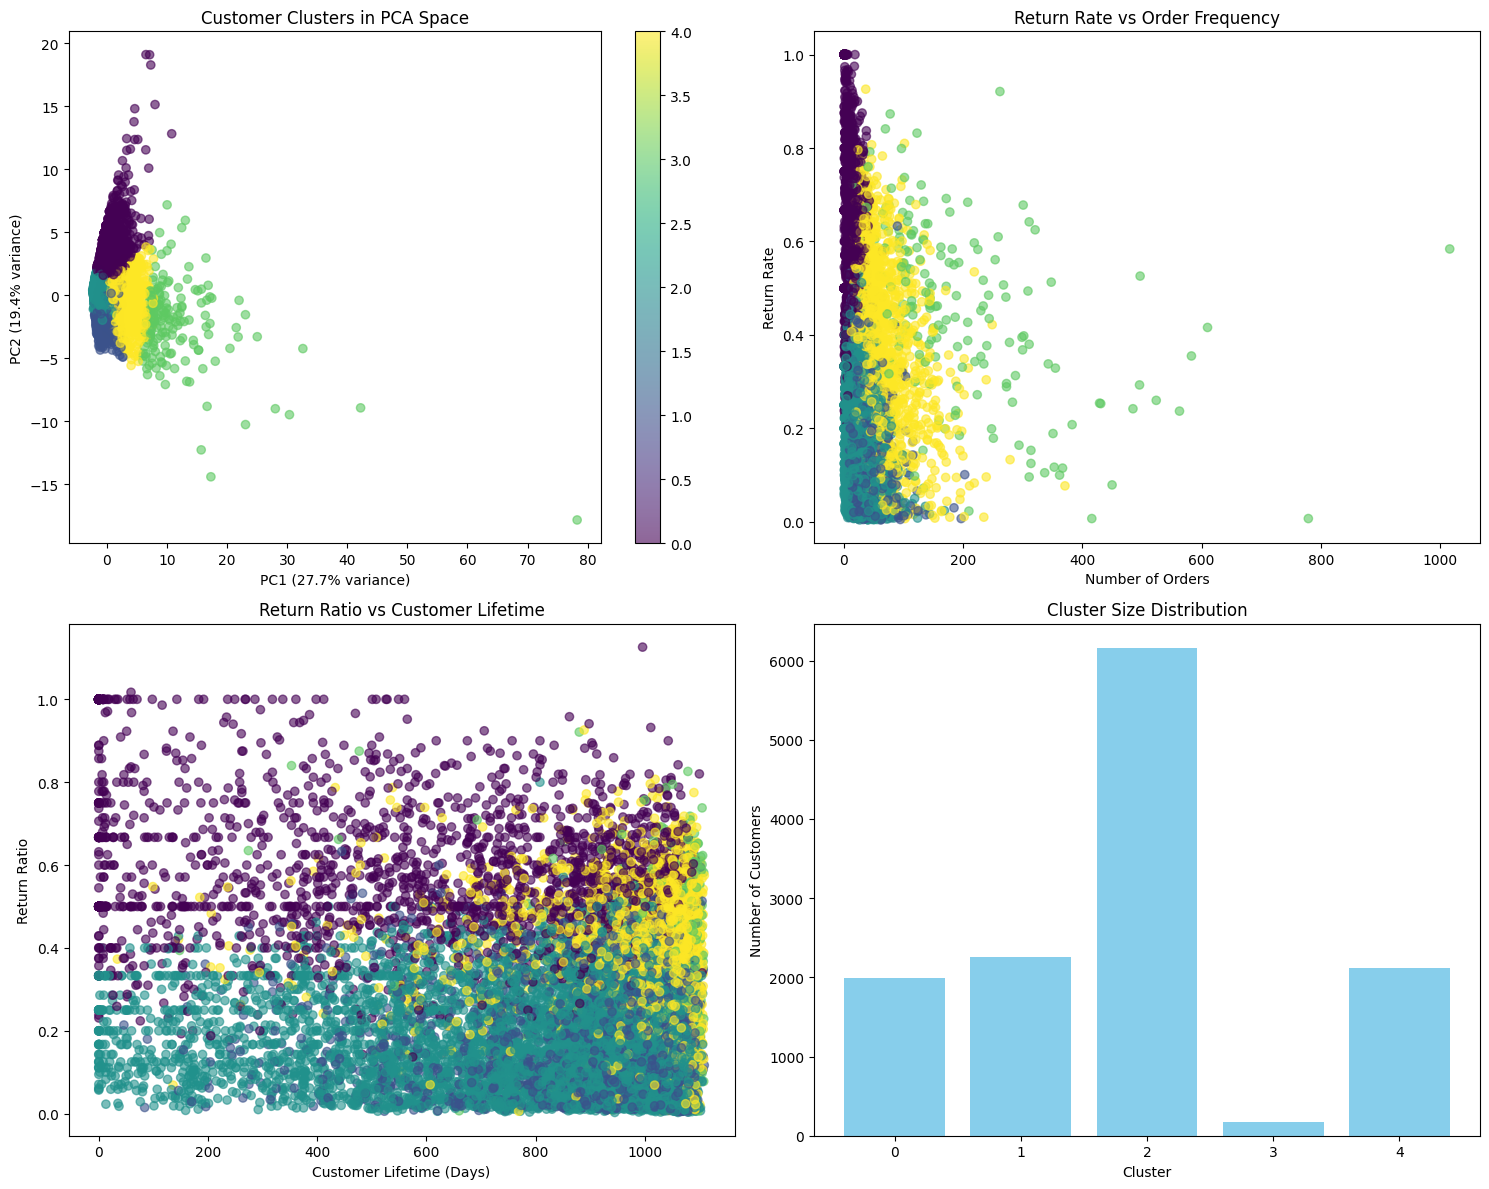

Clusters visualized successfully.


In [17]:
# Visualize
print("visualizing clusters...")
analyzer.visualize_clusters()
print("Clusters visualized successfully.")


In [18]:
# Export results
print("exporting results...")
results = analyzer.export_results()
print("Results exported successfully.")


exporting results...
=== CLUSTER ANALYSIS ===
         AVG_ORDERS  CUSTOMER_COUNT  AVG_RETURN_RATE  AVG_RETURN_RATIO  \
CLUSTER                                                                  
0            10.373            1995            0.618             0.613   
1            27.612            2262            0.182             0.176   
2            20.562            6156            0.178             0.172   
3           195.511             176            0.457             0.447   
4            54.303            2120            0.391             0.383   

         AVG_ITEMS_RETURNED  AVG_LIFETIME_DAYS  AVG_RECENT_ORDERS  \
CLUSTER                                                             
0                    22.591            527.647              0.964   
1                    11.980            906.454              2.262   
2                     8.303            803.259              1.648   
3                   239.330           1030.653             17.000   
4                    

Expectations vs Actuals

In [19]:
# Cell: Compare Actual vs Expected Segments  
# ==========================================
print("="*60)
print("ACTUAL CLUSTERS vs EXPECTED SEGMENTS")
print("="*60)

# Get current cluster results
current_clusters = analyzer.customer_features.groupby('CLUSTER').agg({
    'SALES_ORDER_NO_nunique': 'mean',
    'RETURN_RATE': 'mean', 
    'RETURN_RATIO': 'mean',
    'SKU_nunique': 'mean',
    'RECENT_ORDERS': 'mean',
    'AVG_DAYS_TO_RETURN': 'mean',
    'AVG_RETURN_INTENSITY': 'mean',
    'AVG_RETURNS_PER_ORDER': 'mean'
}).round(3)

current_clusters['CUSTOMER_COUNT'] = analyzer.customer_features.groupby('CLUSTER').size()
current_clusters['PERCENTAGE'] = (current_clusters['CUSTOMER_COUNT'] / len(analyzer.customer_features) * 100).round(1)

print("Current cluster characteristics:")
print(current_clusters)

print(f"\n🔍 CLUSTER ANALYSIS:")
for cluster_id in current_clusters.index:
    cluster_data = current_clusters.loc[cluster_id]
    print(f"\nCluster {cluster_id} ({cluster_data['PERCENTAGE']}% of customers):")
    print(f"  • Avg Orders: {cluster_data['SALES_ORDER_NO_nunique']:.1f}")
    print(f"  • Return Rate: {cluster_data['RETURN_RATE']:.3f}")
    print(f"  • Return Ratio: {cluster_data['RETURN_RATIO']:.3f}")
    print(f"  • Recent Orders: {cluster_data['RECENT_ORDERS']:.1f}")
    print(f"  • Days to Return: {cluster_data['AVG_DAYS_TO_RETURN']:.1f}")
    
    # Classify this cluster
    if (cluster_data['SALES_ORDER_NO_nunique'] > 50 and 
        cluster_data['RETURN_RATE'] < 0.3):
        suggested_type = "🌟 VIP CHAMPION candidate"
    elif cluster_data['RETURN_RATE'] > 0.6:
        suggested_type = "⚠️  HEAVY RETURNER candidate"  
    elif (cluster_data['RECENT_ORDERS'] < 2 and 
          cluster_data['SALES_ORDER_NO_nunique'] > 15):
        suggested_type = "📉 CHURN RISK candidate"
    elif cluster_data['SKU_nunique'] > 100:
        suggested_type = "🔍 EXPLORER candidate"
    else:
        suggested_type = "📊 STANDARD customer"
    
    print(f"  → {suggested_type}")

print(f"\n💡 RECOMMENDATIONS FOR BETTER SEGMENTATION:")
print("1. If clusters are too broad, try increasing n_clusters to 6-8")
print("2. Consider feature engineering (ratios, interaction terms)")
print("3. Remove or weight features that aren't separating well")
print("4. Check if any features need transformation (log, scaling)")

ACTUAL CLUSTERS vs EXPECTED SEGMENTS
Current cluster characteristics:
         SALES_ORDER_NO_nunique  RETURN_RATE  RETURN_RATIO  SKU_nunique  \
CLUSTER                                                                   
0                        10.373        0.618         0.613       37.753   
1                        27.612        0.182         0.176       69.984   
2                        20.562        0.178         0.172       53.379   
3                       195.511        0.457         0.447      522.324   
4                        54.303        0.391         0.383      137.279   

         RECENT_ORDERS  AVG_DAYS_TO_RETURN  AVG_RETURN_INTENSITY  \
CLUSTER                                                            
0                0.964              17.184                 1.001   
1                2.262              18.055                 0.996   
2                1.648              19.115                 0.997   
3               17.000              23.265                 0.997

High-risk clusters identified: [0, 3]
Total high-risk customers: 2171
High-risk customer list saved to 'high_risk_customers.csv'

MARKETING CAMPAIGN RECOMMENDATIONS

📊 HIGH RISK - Heavy Returners
   👥 Customers: 1995
   🎯 Action: Immediate retention intervention needed
   📧 Sample emails: ['trinahale1980@gmail.com', 'trinahebert@att.net', 'trinaise13@gmail.com']

📊 STANDARD - Balanced Customers
   👥 Customers: 2262
   🎯 Action: Standard marketing engagement
   📧 Sample emails: ['trinah2o@hotmail.com', 'trinamilamb@hotmail.com', 'trinamoccia@gmail.com']

📊 STANDARD - Balanced Customers
   👥 Customers: 6156
   🎯 Action: Standard marketing engagement
   📧 Sample emails: ['trinajablonsky@yahoo.com', 'trinaleeroberts@yahoo.com', 'trinamartin16@yahoo.com']

📊 HIGH RISK - Heavy Returners
   👥 Customers: 176
   🎯 Action: Immediate retention intervention needed
   📧 Sample emails: ['trinityjshi@gmail.com', 'trish.brown22@gmail.com', 'trishajumper@gmail.com']

📊 EXPLORERS - High Product Variety


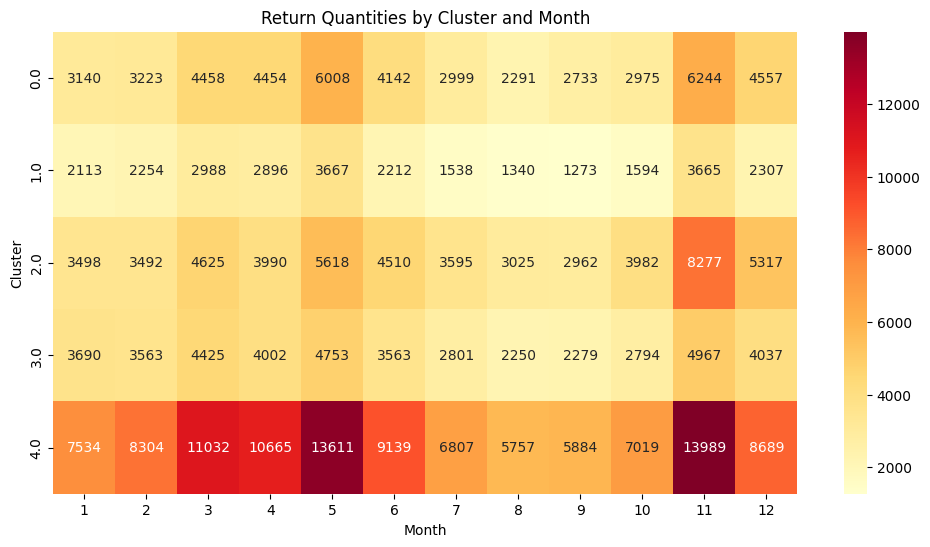

In [20]:
# High-risk customers (for retention campaigns)
high_risk_clusters = [i for i, info in interpretations.items() 
    if 'HIGH RISK' in info['type'] or 'CHURN RISK' in info['type']]

if high_risk_clusters:
    print(f"High-risk clusters identified: {high_risk_clusters}")
    high_risk_customers = []
    for cluster_id in high_risk_clusters:
        customers = analyzer.get_cluster_customers(cluster_id)
        high_risk_customers.extend(customers)
    
    print(f"Total high-risk customers: {len(high_risk_customers)}")
    
    # Save high-risk customer list
    pd.DataFrame({'CUSTOMER_EMAILID': high_risk_customers}).to_csv('high_risk_customers.csv', index=False)
    print("High-risk customer list saved to 'high_risk_customers.csv'")

# Loyal customers (for rewards programs)
loyal_clusters = [i for i, info in interpretations.items() 
    if 'LOYAL' in info['type']]

if loyal_clusters:
    print(f"\nLoyal clusters identified: {loyal_clusters}")
    loyal_customers = []
    for cluster_id in loyal_clusters:
        customers = analyzer.get_cluster_customers(cluster_id)
        loyal_customers.extend(customers)
    
    print(f"Total loyal customers: {len(loyal_customers)}")
    
    # Save loyal customer list
    pd.DataFrame({'CUSTOMER_EMAILID': loyal_customers}).to_csv('loyal_customers.csv', index=False)
    print("Loyal customer list saved to 'loyal_customers.csv'")
print("\n" + "="*50)
print("MARKETING CAMPAIGN RECOMMENDATIONS")
print("="*50)

for cluster_id, info in interpretations.items():
    customers = analyzer.get_cluster_customers(cluster_id)
    print(f"\n📊 {info['type']}")
    print(f"   👥 Customers: {info['customers']}")
    print(f"   🎯 Action: {info['action']}")
    print(f"   📧 Sample emails: {customers[:3] if len(customers) >= 3 else customers}")

# Cell 12: Additional Analysis (Optional)
# =======================================
# You can add custom analysis here based on your specific business needs

# Example: Analyze return patterns by product category
if 'Q_CLS_ID' in df.columns:
    print("\n" + "="*40)
    print("PRODUCT CATEGORY ANALYSIS")
    print("="*40)

    # Get the cluster assignments
    customer_clusters = analyzer.customer_features[['CLUSTER']].reset_index()
    
    # Merge with original data to add cluster information
    df_with_clusters = df.merge(customer_clusters, on='CUSTOMER_EMAILID', how='left')
    
    # Now analyze by cluster and category (only for customers with clusters)
    category_returns = df_with_clusters[df_with_clusters['CLUSTER'].notna()].groupby(['CLUSTER', 'Q_CLS_ID']).agg({
        'RETURN_QTY': 'sum',
        'CUSTOMER_EMAILID': 'nunique'
    }).round(2)

# Example: Time-based analysis
print("\n" + "="*40)
print("SEASONAL RETURN PATTERNS")
print("="*40)

df['ORDER_MONTH'] = pd.to_datetime(df['ORDER_DATE']).dt.month
df_with_clusters['ORDER_MONTH'] = pd.to_datetime(df_with_clusters['ORDER_DATE']).dt.month
monthly_returns = df_with_clusters[df_with_clusters['CLUSTER'].notna()].groupby(['CLUSTER', 'ORDER_MONTH'])['RETURN_QTY'].sum().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(monthly_returns, annot=True, cmap='YlOrRd', fmt='.0f')
plt.title('Return Quantities by Cluster and Month')
plt.xlabel('Month')
plt.ylabel('Cluster')
plt.show()

In [21]:
# Cell: Compare Actual vs Expected Segments  
# ==========================================
print("="*60)
print("ACTUAL CLUSTERS vs EXPECTED SEGMENTS")
print("="*60)

# Get current cluster results with interpretations
cluster_summary, interpretations = analyzer.analyze_clusters()

# Get detailed cluster characteristics
current_clusters = analyzer.customer_features.groupby('CLUSTER').agg({
    'SALES_ORDER_NO_nunique': 'mean',
    'RETURN_RATE': 'mean', 
    'RETURN_RATIO': 'mean',
    'SKU_nunique': 'mean',
    'RECENT_ORDERS': 'mean',
    'AVG_DAYS_TO_RETURN': 'mean',
    'AVG_RETURN_INTENSITY': 'mean',
    'AVG_RETURNS_PER_ORDER': 'mean',
    'CUSTOMER_LIFETIME_DAYS': 'mean'
}).round(3)

current_clusters['CUSTOMER_COUNT'] = analyzer.customer_features.groupby('CLUSTER').size()
current_clusters['PERCENTAGE'] = (current_clusters['CUSTOMER_COUNT'] / len(analyzer.customer_features) * 100).round(1)

print("CLUSTER COMPARISON TABLE:")
print(current_clusters)

print(f"\n🔍 DETAILED CLUSTER vs EXPECTATION ANALYSIS:")
print("="*80)

for cluster_id in current_clusters.index:
    cluster_data = current_clusters.loc[cluster_id]
    actual_name = interpretations[cluster_id]['type']
    actual_action = interpretations[cluster_id]['action']
    
    print(f"\n📊 CLUSTER {cluster_id}")
    print(f"   Current Algorithm Says: '{actual_name}'")
    print(f"   Size: {cluster_data['CUSTOMER_COUNT']} customers ({cluster_data['PERCENTAGE']}%)")
    print(f"   Action: {actual_action}")
    
    print(f"\n   📈 Key Metrics:")
    print(f"     • Avg Orders: {cluster_data['SALES_ORDER_NO_nunique']:.1f}")
    print(f"     • Return Rate: {cluster_data['RETURN_RATE']:.3f}")
    print(f"     • Return Ratio: {cluster_data['RETURN_RATIO']:.3f}")
    print(f"     • Product Variety: {cluster_data['SKU_nunique']:.0f}")
    print(f"     • Recent Orders: {cluster_data['RECENT_ORDERS']:.1f}")
    print(f"     • Days to Return: {cluster_data['AVG_DAYS_TO_RETURN']:.1f}")
    print(f"     • Lifetime: {cluster_data['CUSTOMER_LIFETIME_DAYS']:.0f} days")
    
    # Manual classification based on expected segments
    if (cluster_data['SALES_ORDER_NO_nunique'] > 50 and 
        cluster_data['RETURN_RATE'] < 0.3):
        expected_match = "🌟 VIP CHAMPIONS"
        match_quality = "✅ STRONG MATCH" if "VIP" in actual_name else "❌ MISMATCH"
    elif (cluster_data['RETURN_RATE'] > 0.6 and 
          cluster_data['RETURN_RATIO'] > 0.5):
        expected_match = "⚠️  HEAVY RETURNERS"
        match_quality = "✅ STRONG MATCH" if "HEAVY" in actual_name or "HIGH RISK" in actual_name else "❌ MISMATCH"
    elif (cluster_data['RECENT_ORDERS'] < 2 and 
          cluster_data['SALES_ORDER_NO_nunique'] > 10):
        expected_match = "📉 CHURN RISK"
        match_quality = "✅ STRONG MATCH" if "CHURN" in actual_name or "AT RISK" in actual_name else "❌ MISMATCH"
    elif cluster_data['SKU_nunique'] > 100:
        expected_match = "🔍 EXPLORERS"
        match_quality = "✅ STRONG MATCH" if "EXPLORER" in actual_name else "❌ MISMATCH"
    else:
        expected_match = "📊 STANDARD/BALANCED"
        match_quality = "✅ STRONG MATCH" if "STANDARD" in actual_name else "⚠️  ACCEPTABLE"
    
    print(f"\n   🎯 Business Logic Says: '{expected_match}'")
    print(f"   🔄 Match Quality: {match_quality}")
    
    # Suggestions for improvement
    if "MISMATCH" in match_quality:
        print(f"   💡 Suggestion: Features may need adjustment to better capture {expected_match.split()[1]} behavior")
    
    print("-" * 80)

print(f"\n📋 OVERALL SEGMENTATION ASSESSMENT:")

# Count matches
strong_matches = sum(1 for cluster_id in current_clusters.index 
                    if any(keyword in interpretations[cluster_id]['type'].upper() 
                          for keyword in ['VIP', 'HEAVY', 'HIGH RISK', 'CHURN', 'AT RISK', 'EXPLORER', 'STANDARD']))

print(f"   • Strong business logic matches: {strong_matches}/{len(current_clusters)} clusters")
print(f"   • Largest cluster: {current_clusters['PERCENTAGE'].max():.1f}% (should be <50%)")
print(f"   • Smallest cluster: {current_clusters['PERCENTAGE'].min():.1f}% (should be >5%)")

print(f"\n💡 RECOMMENDATIONS FOR IMPROVEMENT:")
if current_clusters['PERCENTAGE'].max() > 50:
    print("   • Increase number of clusters (try 6-8) - largest cluster too dominant")
if current_clusters['PERCENTAGE'].min() < 3:
    print("   • Consider reducing clusters or feature engineering - very small clusters")
if strong_matches < len(current_clusters) * 0.6:
    print("   • Feature weights may need adjustment for better business alignment")

print("   • Consider adding interaction features (e.g., return_rate * recent_orders)")
print("   • Try different clustering algorithms (DBSCAN, Gaussian Mixture)")
print("   • Remove features with low variance or high correlation")

ACTUAL CLUSTERS vs EXPECTED SEGMENTS
=== CLUSTER ANALYSIS ===
         AVG_ORDERS  CUSTOMER_COUNT  AVG_RETURN_RATE  AVG_RETURN_RATIO  \
CLUSTER                                                                  
0            10.373            1995            0.618             0.613   
1            27.612            2262            0.182             0.176   
2            20.562            6156            0.178             0.172   
3           195.511             176            0.457             0.447   
4            54.303            2120            0.391             0.383   

         AVG_ITEMS_RETURNED  AVG_LIFETIME_DAYS  AVG_RECENT_ORDERS  \
CLUSTER                                                             
0                    22.591            527.647              0.964   
1                    11.980            906.454              2.262   
2                     8.303            803.259              1.648   
3                   239.330           1030.653             17.000   
4    